# Getting started

### Initialize streams

[Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects define material flow rates along with its thermodynamic state. Before creating streams, a [Thermo](https://thermosteam.readthedocs.io/en/latest/Thermo.html) property package must be defined. Alternatively, we can just pass chemical names and BioSTEAM will automatically create a property package based on ideal mixing rules and UNIFAC activity coefficients for thermodynamic equilibrium. More complex packages can be defined through Thermosteam, BioSTEAM's premier thermodynamic engine. Please visit [Thermosteam's documentation](https://thermosteam.readthedocs.io/en/latest/index.html) for a complete tutorial on [Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects and how to create a property package. In this example, a simple feed stream with a few common chemicals will be initialized:

In [1]:
import biosteam as bst
bst.settings.set_thermo(['Water', 'Methanol', 'Glycerol'])
feed = bst.Stream(Water=20, Glycerol=10)
feed.show()

Stream: s1
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (kmol/hr): Water     20
                 Glycerol  10


Set prices for performing techno-economic analysis later:

In [2]:
feed.price = 0.15 # USD/kg
feed.cost # USD/hr

192.18657

### Process settings

**Process settings include price of feeds and products, conditions of utilities, and the chemical engineering plant cost index. These should be set before simulating a system.**

Set the chemical engineering plant cost index:

In [3]:
bst.CE # Default year is 2017

567.5

In [4]:
bst.CE = 603.1 # To year 2018

Set [PowerUtility](https://biosteam.readthedocs.io/en/latest/PowerUtility.html) options:

In [5]:
bst.PowerUtility.price # Default price (USD/kJ)

0.0782

In [6]:
bst.PowerUtility.price = 0.065 # Adjust price

Set [HeatUtility](https://biosteam.readthedocs.io/en/latest/HeatUtility.html) options via [UtilityAgent](https://biosteam.readthedocs.io/en/latest/UtilityAgent.html) objects, which are basically [Stream](https://thermosteam.readthedocs.io/en/latest/Stream.html) objects with additional attributes to describe a utility agent:

In [7]:
bst.HeatUtility.cooling_agents # All available cooling agents

[<UtilityAgent: cooling_water>,
 <UtilityAgent: chilled_water>,
 <UtilityAgent: chilled_brine>]

In [8]:
cw = bst.HeatUtility.get_cooling_agent('cooling_water')
cw # A UtilityAgent


UtilityAgent: cooling_water
 phase: 'l', T: 305.37 K, P: 101325 Pa
 heat_transfer_price: 0 USD/kJ
 regeneration_price: 0.000488 USD/kmol
 heat_transfer_efficiency: 1.000
 T_limit: 325 K
 flow (kmol/hr): Water  1


In [9]:
# Price of regenerating the utility in USD/kmol
cw.regeneration_price

0.00048785

In [10]:
# Other utilities may be priced for amount of heat transfered in USD/kJ
chilled_water = bst.HeatUtility.get_cooling_agent('chilled_water')
chilled_water.heat_transfer_price

5e-06

In [11]:
cw.T = 302 # Change the temperature of cooling water (K)

In [12]:
bst.HeatUtility.heating_agents # All available heating agents

[<UtilityAgent: low_pressure_steam>,
 <UtilityAgent: medium_pressure_steam>,
 <UtilityAgent: high_pressure_steam>]

In [13]:
lps = bst.HeatUtility.get_heating_agent('low_pressure_steam') # A UtilityAgent
lps # Note that because utility changes phase, T_limit is None

UtilityAgent: low_pressure_steam
 phase: 'g', T: 411.49 K, P: 344738 Pa
 heat_transfer_price: 0 USD/kJ
 regeneration_price: 0.238 USD/kmol
 heat_transfer_efficiency: 0.950
 T_limit: None
 flow (kmol/hr): Water  1


In [14]:
lps.regeneration_price = 0.20 # Adjust price (USD/kmol)

### Find design requirements and cost with Unit objects

[Creating a Unit](https://biosteam.readthedocs.io/en/latest/Creating a Unit.html) can be flexible. But in summary, a [Unit](https://biosteam.readthedocs.io/en/latest/Unit.html) object is initialized with an ID, and unit-specific arguments. BioSTEAM includes [essential unit operations](https://biosteam.readthedocs.io/en/latest/units/units.html) with rigorous modeling and design algorithms. Here we create a [Flash](https://biosteam.readthedocs.io/en/latest/units/Flash.html) object as an example:

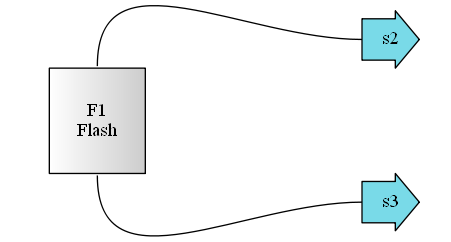

Flash: F1
ins...
[0] missing stream
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [15]:
from biosteam import units

# Specify vapor fraction and isobaric conditions
F1 = units.Flash('F1', V=0.5, P=101325)
F1

Note that, by default, Missing Stream objects are given to inputs, `ins`, and empty streams to outputs, `outs`:

In [16]:
F1.ins

[<MissingStream>]

In [17]:
F1.outs

[<Stream: s2>, <Stream: s3>]

You can connect streams by setting the `ins` and `outs`:

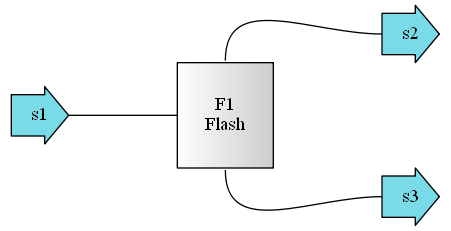

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     20
                    Glycerol  10
outs...
[0] s2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s3
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [18]:
F1.ins[0] = feed
F1

To simulate the flash, use the `simulate` method:

In [19]:
F1.simulate()
F1.show()

Flash: F1
ins...
[0] s1
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     20
                    Glycerol  10
outs...
[0] s2
    phase: 'g', T: 382.91 K, P: 101325 Pa
    flow (kmol/hr): Water     15
                    Glycerol  0.00534
[1] s3
    phase: 'l', T: 382.91 K, P: 101325 Pa
    flow (kmol/hr): Water     5.01
                    Glycerol  9.99


The `results` method returns simulation results:

In [20]:
F1.results() # Default returns DataFrame object with units

Flash                                 Units            F1
Low pressure steam  Duty              kJ/hr      1.03e+06
                    Flow            kmol/hr          26.4
                    Cost             USD/hr          5.28
Design              Vessel type                  Vertical
                    Length               ft          37.5
                    Diameter             ft           6.5
                    Weight               lb      1.28e+04
                    Wall thickness       in         0.375
                    Material                 Carbon steel
Purchase cost       Flash               USD      8.14e+04
                    Heat exchanger      USD      3.87e+03
Total purchase cost                     USD      8.53e+04
Utility cost                         USD/hr          5.28

In [21]:
F1.results(with_units=False) # Returns Series object without units

Low pressure steam   Duty                  1.03e+06
                     Flow                      26.4
                     Cost                      5.28
Design               Vessel type           Vertical
                     Length                    37.5
                     Diameter                   6.5
                     Weight                1.28e+04
                     Wall thickness           0.375
                     Material          Carbon steel
Purchase cost        Flash                 8.14e+04
                     Heat exchanger        3.87e+03
Total purchase cost                        8.53e+04
Utility cost                                   5.28
Name: F1, dtype: object

### Solve recycle loops and process specifications with System objects

**Designing a chemical process is no easy task. A simple recycle process consisting of a flash with a partial liquid recycle is presented here.**

Create a [Mixer](https://biosteam.readthedocs.io/en/latest/Mixer.html) object and a [Splitter](https://biosteam.readthedocs.io/en/latest/Splitter.html) object:

In [22]:
M1 = units.Mixer('M1')
S1 = units.Splitter('S1', outs=('liquid_recycle', 'liquid_product'),
                    split=0.5) # Split to 0th output stream
F1.outs[0].ID = 'vapor_product'
F1.outs[1].ID = 'liquid'

You can [find unit operations and manage flowsheets](https://biosteam.readthedocs.io/en/master/tutorial/Managing%20flowsheets.html) with `find`:

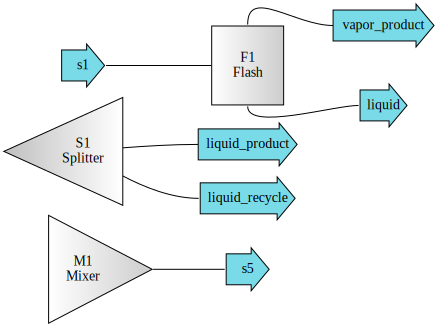

In [23]:
bst.find.diagram()

Connect streams and make a recycle loop using [-pipe- notation](https://biosteam.readthedocs.io/en/latest/Using -pipe- notation.html):

In [24]:
feed = bst.Stream('feed', Glycerol=100, Water=450)

# Broken down -pipe- notation
[S1-0, feed]-M1     # M1.ins[:] = [S1.outs[0], feed]
M1-F1               # F1.ins[:] = M1.outs
F1-1-S1             # S1.ins[:] = [F1.outs[1]]

# All together
[S1-0, feed]-M1-F1-1-S1;

Now lets check the diagram again:

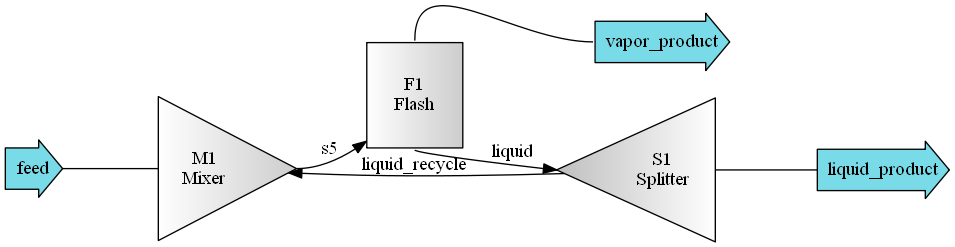

In [25]:
bst.find.diagram(format='png')

A [System](https://biosteam.readthedocs.io/en/latest/System.html) object can be created directly from the flowsheet:

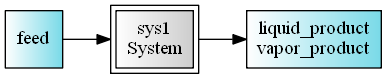

System: sys1
 recycle: liquid_recycle
 path: (M1, F1, S1)
 convergence error: Flow rate   0.00e+00 kmol/hr
                    Temperature 0.00e+00 K
 iterations: 0


In [26]:
sys1 = bst.find.create_system('sys1')
sys1

Alternatively, create a [System](https://biosteam.readthedocs.io/en/latest/System.html) object by specifying an ID, a `recycle` stream and a `path` of units to run element by element:

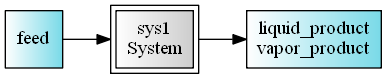

System: sys1
 recycle: liquid_recycle
 path: (M1, F1, S1)
 convergence error: Flow rate   0.00e+00 kmol/hr
                    Temperature 0.00e+00 K
 iterations: 0


In [27]:
sys1 = bst.System('sys1', path=(M1, F1, S1), recycle=S1-0) # recycle=S1.outs[0]
sys1

View the System object as a Graphviz diagram:

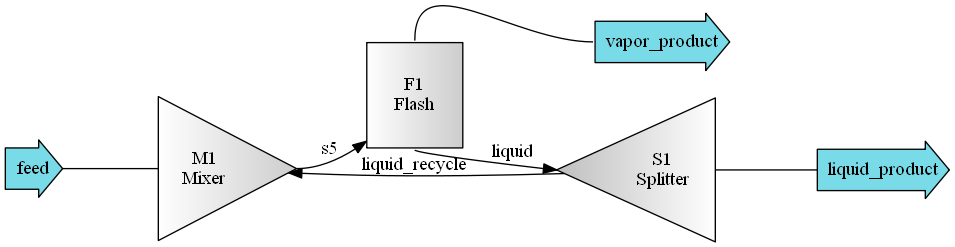

In [28]:
sys1.diagram()

Simulate the System object:

In [29]:
sys1.simulate()
sys1.show()

System: sys1
 recycle: liquid_recycle
 path: (M1, F1, S1)
 convergence error: Flow rate   5.91e-03 kmol/hr
                    Temperature 8.44e-02 K
 iterations: 5


In [30]:
F1.show()

Flash: F1
ins...
[0] s5  from  Mixer-M1
    phase: 'l', T: 326.07 K, P: 101325 Pa
    flow (kmol/hr): Water     533
                    Glycerol  200
outs...
[0] vapor_product
    phase: 'g', T: 377.45 K, P: 101325 Pa
    flow (kmol/hr): Water     367
                    Glycerol  0.0795
[1] liquid  to  Splitter-S1
    phase: 'l', T: 377.45 K, P: 101325 Pa
    flow (kmol/hr): Water     167
                    Glycerol  200


In [31]:
F1.results()

Flash                                 Units            F1
Low pressure steam  Duty              kJ/hr      2.15e+07
                    Flow            kmol/hr           553
                    Cost             USD/hr           111
Design              Vessel type                  Vertical
                    Length               ft          35.5
                    Diameter             ft             6
                    Weight               lb      1.12e+04
                    Wall thickness       in         0.375
                    Material                 Carbon steel
Purchase cost       Flash               USD      7.45e+04
                    Heat exchanger      USD      5.51e+03
Total purchase cost                     USD         8e+04
Utility cost                         USD/hr           111

Save a system report:

In [32]:
sys1.save_report('Example.xlsx') # Try this on your computer and open excel

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Cannot find TEA object in <System: sys1>. Ignoring TEA sheets.
  """Entry point for launching an IPython kernel.


Once process settings are set and the system is simulated, it is possible to perform [techno-economic analysis](https://biosteam.readthedocs.io/en/latest/Techno-economic analysis.html). If a [TEA](https://biosteam.readthedocs.io/en/latest/TEA.html) object of the system was initialized, TEA results would also appear in the report.

### Join the community!

BioSTEAM will become more relevant with communitity involvement. It is strongly encouraged to share designs and new [Unit subclasses](https://biosteam.readthedocs.io/en/latest/Inheriting from Unit.html), no matter how preliminary or rigorous they are.